In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

import openpyxl

import sys
import os
import runpy

import requests
from io import StringIO
import json

import json
import glob
from pathlib import Path

import datetime
from dateutil import parser
import pickle
import re

## CREATE LOOKUP MASTER TABLE 

In [2]:
# PATHS
INPUT_EXCEL = r"C:\Users\jarem\OneDrive - London School of Economics\YEAR 2\1. Policy paper\policy-paper-repo\data\inputs\shapefiles\polska\teryt_klucz_powiaty_gminy_lata_1999_2025-1.xlsx"
OUTPUT_PICKLE = r"C:\Users\jarem\OneDrive - London School of Economics\YEAR 2\1. Policy paper\policy-paper-repo\data\outputs\teryt_lookup\teryt_lookup_2025.pkl"

print("Reading Excel file... (This may take a moment)")
# Load only necessary columns
cols = ['region', 'nazwa_powiatu', 'nazwa_gminy', 'teryt_2025', 'zmiana_opis']
df_g = pd.read_excel(INPUT_EXCEL, sheet_name='gminy', dtype=str, usecols=cols)

# --- 1. NORMALIZATION LOGIC ---
def normalize_series(s):
    return (s.astype(str).str.lower()
            .str.replace(r'\s+od\s+\d{4}', '', regex=True) # Remove ' od 2002'
            .str.replace('m.st.', '', regex=False)
            .str.replace('m.', '', regex=False)
            .str.replace('st.', '', regex=False)
            .str.replace('miasto', '', regex=False)
            .str.replace('powiat', '', regex=False)
            .str.replace('-', '', regex=False)
            .str.replace('.', '', regex=False)
            .str.replace(' ', '', regex=False))

print("Normalizing names...")
woj_id = df_g['region'].astype(str).str.split('.').str[0].str.zfill(2)
pow_norm = normalize_series(df_g['nazwa_powiatu'])
gmi_norm = normalize_series(df_g['nazwa_gminy'])
target_id = df_g['teryt_2025'].astype(str).str.split('.').str[0].str.zfill(7)

# --- 2. BUILD PRIMARY MAP (Current Names) ---
# Key: (WojID, PowiatNorm, GminaNorm) -> Value: TERYT25
primary_lookup = dict(zip(zip(woj_id, pow_norm, gmi_norm), target_id))

# --- 3. MINING HISTORY (Renames & Mergers) ---
print("Mining historical changes...")

# A. Renames
mask_rename = df_g['zmiana_opis'].str.contains('zmiana nazwy z', na=False, case=False)
if mask_rename.any():
    old_names = df_g.loc[mask_rename, 'zmiana_opis'].str.extract(r'zmiana nazwy z\s+(.+?)\s+na', flags=re.IGNORECASE)[0]
    old_names_norm = normalize_series(old_names)
    
    # Map Old Name -> Current ID
    hist_keys = zip(woj_id[mask_rename], pow_norm[mask_rename], old_names_norm)
    primary_lookup.update(dict(zip(hist_keys, target_id[mask_rename])))

# B. Absorptions (Mergers)
mask_absorb = df_g['zmiana_opis'].str.contains('włączenie gminy', na=False, case=False)
if mask_absorb.any():
    absorbed_names = df_g.loc[mask_absorb, 'zmiana_opis'].str.extract(r'włączenie gminy\s+(.+?)(?:\s|$)', flags=re.IGNORECASE)[0]
    absorbed_norm = normalize_series(absorbed_names)
    
    # Map Absorbed Name -> Survivor ID
    absorb_keys = zip(woj_id[mask_absorb], pow_norm[mask_absorb], absorbed_norm)
    primary_lookup.update(dict(zip(absorb_keys, target_id[mask_absorb])))

# --- 4. BUILD FALLBACK MAP (Woj + Gmina only) ---
# Useful for cities like "M. Łódź" where powiat matching often fails
df_g['woj_id'] = woj_id
df_g['gmi_norm'] = gmi_norm
df_g['target_id'] = target_id

# Only keep unique mappings (e.g. if 'Nowa Wieś' appears twice in a Voivodeship, drop it)
unique_counts = df_g.groupby(['woj_id', 'gmi_norm'])['target_id'].nunique()
valid_indices = unique_counts[unique_counts == 1].index

fallback_df = df_g.set_index(['woj_id', 'gmi_norm']).loc[valid_indices]
fallback_lookup = fallback_df['target_id'].to_dict()

# --- 5. SAVE TO DISK ---
print(f"Saving lookup tables to {OUTPUT_PICKLE}...")
with open(OUTPUT_PICKLE, 'wb') as f:
    pickle.dump((primary_lookup, fallback_lookup), f)

print("You can now load this file in your main script.")

Reading Excel file... (This may take a moment)
Normalizing names...
Mining historical changes...
Saving lookup tables to C:\Users\jarem\OneDrive - London School of Economics\YEAR 2\1. Policy paper\policy-paper-repo\data\outputs\teryt_lookup\teryt_lookup_2025.pkl...
You can now load this file in your main script.


In [3]:
# PATHS
INPUT_EXCEL = r"C:\Users\jarem\OneDrive - London School of Economics\YEAR 2\1. Policy paper\policy-paper-repo\data\inputs\shapefiles\polska\teryt_klucz_powiaty_gminy_lata_1999_2025-1.xlsx"
OUTPUT_HIERARCHY = r"C:\Users\jarem\OneDrive - London School of Economics\YEAR 2\1. Policy paper\policy-paper-repo\data\outputs\teryt_lookup\powiat_structure_2025.pkl"

print("Reading TERYT structure...")
# We need: Region, Powiat ID, and Gmina ID
cols = ['region', 'powiat', 'teryt_2025']
df = pd.read_excel(INPUT_EXCEL, sheet_name='gminy', dtype=str, usecols=cols)

# Normalize IDs to match your main data format
# Woj: 2 digits, Powiat: 4 digits, Gmina: 7 digits
df['woj_id'] = df['region'].str.split('.').str[0].str.zfill(2)
# In TERYT 'powiat' column is often just the suffix (e.g. '01'), we need full '0201'
# Usually teryt_2025 starts with the 4-digit powiat code.
df['powiat_id'] = df['teryt_2025'].str[:4]
df['gmina_id'] = df['teryt_2025'].str.split('.').str[0].str.zfill(7)

# Create the Map: (Woj_ID, Pow_ID) -> List of [Gmina_IDs]
# We group by Woj and Pow, and collect all Gminas into a list
hierarchy_map = df.groupby(['woj_id', 'powiat_id'])['gmina_id'].apply(list).to_dict()

print(f"Mapped {len(hierarchy_map)} powiats. Example: Powiat 0201 contains {len(hierarchy_map.get(('02','0201'), []))} gminas.")

# Save
with open(OUTPUT_HIERARCHY, 'wb') as f:
    pickle.dump(hierarchy_map, f)
    
print("Hierarchy map saved.")

Reading TERYT structure...
Mapped 380 powiats. Example: Powiat 0201 contains 6 gminas.
Hierarchy map saved.


## TERYT MATCHING FOR 2007 - 2013

#### Read in data and clean

IMPORTANT: dropped rows with NA for gmina or powiat

In [4]:
from GUS_processing_functions import date_columns, data_types, assign_geo_ids, aggregate_funding_by_gmina, disaggregate_powiat_funding

In [5]:
umowy_200713_infered_distributed = pd.read_csv(r"C:\Users\jarem\OneDrive - London School of Economics\YEAR 2\1. Policy paper\policy-paper-repo\data\clean\treatment\eu_flows\intermediary\umowy_200713_infered_distributed.csv"
                                            , low_memory=False)

In [6]:
for col in date_columns:
    umowy_200713_infered_distributed[col] = pd.to_datetime(
        umowy_200713_infered_distributed[col],
        errors="coerce"   
    )

In [7]:
# umowy_200713_infered_distributed.head(), 
umowy_200713_infered_distributed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296875 entries, 0 to 296874
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   ID                             296875 non-null  object        
 1   project_title                  296875 non-null  object        
 2   program                        296875 non-null  object        
 3   priority_code                  296875 non-null  object        
 4   action_code                    296875 non-null  object        
 5   subaction_code                 113811 non-null  object        
 6   voviodeship                    296875 non-null  object        
 7   powiat                         296875 non-null  object        
 8   gmina                          296875 non-null  object        
 9   total_value_PLN                296875 non-null  float64       
 10  Wydatki kwalifikowalne         296875 non-null  float64       
 11  

In [8]:
# umowy_200713_infered_distributed.dropna(subset=["gmina"], inplace=True)
umowy_200713_infered_distributed.dropna(subset=["powiat"], inplace=True)

### Assing geo ids

In [9]:
# Path to the .pkl file you saved
PICKLE_PATH = r"C:\Users\jarem\OneDrive - London School of Economics\YEAR 2\1. Policy paper\policy-paper-repo\data\outputs\teryt_lookup\teryt_lookup_2025.pkl"

# Load the tuple (primary_lookup, fallback_lookup)
with open(PICKLE_PATH, 'rb') as f:
    primary_lookup, fallback_lookup = pickle.load(f)

# Optional: Verify it loaded correctly
print(f"Loaded Primary Map with {len(primary_lookup)} entries.")
print(f"Loaded Fallback Map with {len(fallback_lookup)} entries.")

Loaded Primary Map with 2340 entries.
Loaded Fallback Map with 2153 entries.


In [10]:
umowy_200713_assigned = assign_geo_ids(umowy_200713_infered_distributed)

In [11]:
umowy_200713_assigned.head(3)

,ID,project_title,program,priority_code,action_code,subaction_code,voviodeship,powiat,gmina,total_value_PLN,...,project_completed,signing_date,creation_date_KSI_SIMIK_07_12,start_date,end_date,Year,voivodeship_id,powiat_id,gmina_id,city_id
0,POKL.01.01.00-00-005/10-02,PI - PWP Innowacyjne wsparcie dla Ciebie,Program Operacyjny Kapitał Ludzki,POKL.01.00.00,POKL.01.01.00,NaN,Opolskie,Powiat m. Opole,Opole,226970.980588,...,Tak,2015-01-29,2015-01-29,2011-05-01,2015-05-31,2011,16,1661,1661011,1661011
1,POKL.01.01.00-00-005/10-02,PI - PWP Innowacyjne wsparcie dla Ciebie,Program Operacyjny Kapitał Ludzki,POKL.01.00.00,POKL.01.01.00,NaN,Opolskie,Powiat m. Opole,Opole,302627.974118,...,Tak,2015-01-29,2015-01-29,2011-05-01,2015-05-31,2012,16,1661,1661011,1661011
2,POKL.01.01.00-00-005/10-02,PI - PWP Innowacyjne wsparcie dla Ciebie,Program Operacyjny Kapitał Ludzki,POKL.01.00.00,POKL.01.01.00,NaN,Opolskie,Powiat m. Opole,Opole,302627.974118,...,Tak,2015-01-29,2015-01-29,2011-05-01,2015-05-31,2013,16,1661,1661011,1661011


In [12]:
umowy_200713_assigned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296875 entries, 0 to 296874
Data columns (total 32 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   ID                             296875 non-null  object        
 1   project_title                  296875 non-null  object        
 2   program                        296875 non-null  object        
 3   priority_code                  296875 non-null  object        
 4   action_code                    296875 non-null  object        
 5   subaction_code                 113811 non-null  object        
 6   voviodeship                    296875 non-null  object        
 7   powiat                         296875 non-null  object        
 8   gmina                          296875 non-null  object        
 9   total_value_PLN                296875 non-null  float64       
 10  Wydatki kwalifikowalne         296875 non-null  float64       
 11  

In [13]:
umowy_200713_assigned.to_csv(r"C:\Users\jarem\OneDrive - London School of Economics\YEAR 2\1. Policy paper\policy-paper-repo\data\clean\treatment\eu_flows\intermediary\umowy_200713_assigned.csv", index=False)

In [14]:
umowy_200713_assigned

,ID,project_title,program,priority_code,action_code,subaction_code,voviodeship,powiat,gmina,total_value_PLN,...,project_completed,signing_date,creation_date_KSI_SIMIK_07_12,start_date,end_date,Year,voivodeship_id,powiat_id,gmina_id,city_id
0,POKL.01.01.00-00-005/10-02,PI - PWP Innowacyjne wsparcie dla Ciebie,Program Operacyjny Kapitał Ludzki,POKL.01.00.00,POKL.01.01.00,NaN,Opolskie,Powiat m. Opole,Opole,226970.980588,...,Tak,2015-01-29,2015-01-29,2011-05-01,2015-05-31,2011,16,1661,1661011,1661011
1,POKL.01.01.00-00-005/10-02,PI - PWP Innowacyjne wsparcie dla Ciebie,Program Operacyjny Kapitał Ludzki,POKL.01.00.00,POKL.01.01.00,NaN,Opolskie,Powiat m. Opole,Opole,302627.974118,...,Tak,2015-01-29,2015-01-29,2011-05-01,2015-05-31,2012,16,1661,1661011,1661011
2,POKL.01.01.00-00-005/10-02,PI - PWP Innowacyjne wsparcie dla Ciebie,Program Operacyjny Kapitał Ludzki,POKL.01.00.00,POKL.01.01.00,NaN,Opolskie,Powiat m. Opole,Opole,302627.974118,...,Tak,2015-01-29,2015-01-29,2011-05-01,2015-05-31,2013,16,1661,1661011,1661011
3,POKL.01.01.00-00-005/10-02,PI - PWP Innowacyjne wsparcie dla Ciebie,Program Operacyjny Kapitał Ludzki,POKL.01.00.00,POKL.01.01.00,NaN,Opolskie,Powiat m. Opole,Opole,302627.974118,...,Tak,2015-01-29,2015-01-29,2011-05-01,2015-05-31,2014,16,1661,1661011,1661011
4,POKL.01.01.00-00-005/10-02,PI - PWP Innowacyjne wsparcie dla Ciebie,Program Operacyjny Kapitał Ludzki,POKL.01.00.00,POKL.01.01.00,NaN,Opolskie,Powiat m. Opole,Opole,151313.987059,...,Tak,2015-01-29,2015-01-29,2011-05-01,2015-05-31,2015,16,1661,1661011,1661011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296870,RPSL.01.02.04-00-TY6/11-00,Udział firmy PPHU Satis Małgorzata Sobiś w mis...,Regionalny Program Operacyjny Województwa Śląs...,RPSL.01.00.00,RPSL.01.02.00,RPSL.01.02.04,Śląskie,Powiat m. Częstochowa,M. Częstochowa,2029.047500,...,Tak,2012-08-31,2012-08-31,2011-11-24,2012-07-31,2011,24,2464,2464011,2464011
296871,RPSL.01.02.04-00-TY6/11-00,Udział firmy PPHU Satis Małgorzata Sobiś w mis...,Regionalny Program Operacyjny Województwa Śląs...,RPSL.01.00.00,RPSL.01.02.00,RPSL.01.02.04,Śląskie,Powiat m. Częstochowa,M. Częstochowa,6087.142500,...,Tak,2012-08-31,2012-08-31,2011-11-24,2012-07-31,2012,24,2464,2464011,2464011
296872,RPSL.01.02.04-00-TY7/11-00,Udział w Federalnych Hurtowych Targach Towarów...,Regionalny Program Operacyjny Województwa Śląs...,RPSL.01.00.00,RPSL.01.02.00,RPSL.01.02.04,Śląskie,Powiat m. Jaworzno,M. Jaworzno,34432.095000,...,Tak,2012-09-10,2012-09-10,2011-12-01,2012-03-15,2011,24,2468,2468011,2468011
296873,RPSL.01.02.04-00-TY7/11-00,Udział w Federalnych Hurtowych Targach Towarów...,Regionalny Program Operacyjny Województwa Śląs...,RPSL.01.00.00,RPSL.01.02.00,RPSL.01.02.04,Śląskie,Powiat m. Jaworzno,M. Jaworzno,34432.095000,...,Tak,2012-09-10,2012-09-10,2011-12-01,2012-03-15,2012,24,2468,2468011,2468011


## SPATIAL DISTRIBUTION

In [15]:
# 1. Load and assign IDs (as you did before)
df_with_ids = assign_geo_ids(umowy_200713_infered_distributed)

# 2. Apply Option B: Disaggregate Powiat Funding
PATH_HIERARCHY = r"C:\Users\jarem\OneDrive - London School of Economics\YEAR 2\1. Policy paper\policy-paper-repo\data\outputs\teryt_lookup\powiat_structure_2025.pkl"

df_disaggregated = disaggregate_powiat_funding(df_with_ids, PATH_HIERARCHY)

# 3. Aggregate to final Gmina Panel
# Now every row has a Gmina ID, so this function will capture everything
final_panel = aggregate_funding_by_gmina(df_disaggregated)

# Check result
print(final_panel.head())

No Powiat-only rows found. Returning original.
  voivodeship_id powiat_id gmina_id  Year  EU_subsidy_PLN  total_value_PLN  \
0             02      0201  0201022  2007    2.267063e+06     3.330476e+06   
1             02      0201  0201022  2008    5.632393e+06     1.074916e+07   
2             02      0201  0201022  2009    1.802285e+07     4.658502e+07   
3             02      0201  0201022  2010    3.380571e+07     7.780714e+07   
4             02      0201  0201022  2011    2.305690e+07     5.728763e+07   

    subsidy_PLN   voviodeship                powiat                 gmina  
0  2.267063e+06  Dolnośląskie  Powiat bolesławiecki           Bolesławiec  
1  5.642517e+06  Dolnośląskie  Powiat bolesławiecki  Bolesławiec - miasto  
2  1.929913e+07  Dolnośląskie  Powiat bolesławiecki  Bolesławiec - miasto  
3  3.631653e+07  Dolnośląskie  Powiat bolesławiecki  Bolesławiec - miasto  
4  2.562289e+07  Dolnośląskie  Powiat bolesławiecki  Bolesławiec - miasto  


In [23]:
final_panel.powiat_id.isna().sum()

np.int64(0)

### Import shapefiles

In [17]:
powiaty_geoms = gpd.read_file(r"C:\Users\jarem\OneDrive - London School of Economics\YEAR 2\1. Policy paper\policy-paper-repo\data\inputs\shapefiles\polska\powiaty\powiaty.shp")
gminy_geoms = gpd.read_file(r"C:\Users\jarem\OneDrive - London School of Economics\YEAR 2\1. Policy paper\policy-paper-repo\data\inputs\shapefiles\polska\gminy\gminy.shp")

In [18]:
gmina_level_200713 = aggregate_funding_by_gmina(umowy_200713_assigned) 

In [19]:
gmina_level_200713.to_csv(r"C:\Users\jarem\OneDrive - London School of Economics\YEAR 2\1. Policy paper\policy-paper-repo\data\clean\treatment\eu_flows\final\gmina_level_200713.csv", index=False)

In [ ]:
gminy_geoms["JPT_KOD_JE"] = gminy_geoms["JPT_KOD_JE"].astype(str).str.zfill(7)

0       3215011
1       0619072
2       2214023
3       2214032
4       1406062
         ...   
2472    2815092
2473    2612022
2474    1407062
2475    3207043
2476    2609033
Name: JPT_KOD_JE, Length: 2477, dtype: object

In [39]:
len(final_panel.gmina_id.values[0]), len(gminy_geoms.JPT_KOD_JE.values[0]), 

(7, 7)

In [41]:
gminy_geoms.columns

Index(['gml_id', 'JPT_SJR_KO', 'JPT_POWIER', 'JPT_KOD_JE', 'JPT_NAZWA_',
       'JPT_ORGAN_', 'JPT_JOR_ID', 'WERSJA_OD', 'WERSJA_DO', 'WAZNY_OD',
       'WAZNY_DO', 'JPT_KOD__1', 'JPT_NAZWA1', 'JPT_ORGAN1', 'JPT_WAZNA_',
       'ID_BUFORA_', 'ID_BUFORA1', 'ID_TECHNIC', 'IIP_PRZEST', 'IIP_IDENTY',
       'IIP_WERSJA', 'JPT_KJ_IIP', 'JPT_KJ_I_1', 'JPT_KJ_I_2', 'JPT_OPIS',
       'JPT_SPS_KO', 'ID_BUFOR_1', 'JPT_ID', 'JPT_POWI_1', 'JPT_KJ_I_3',
       'JPT_GEOMET', 'JPT_GEOM_1', 'SHAPE_LENG', 'SHAPE_AREA', 'REGON',
       'RODZAJ', 'geometry'],
      dtype='object')

In [42]:
final_panel_merged = final_panel.merge(gminy_geoms, left_on="gmina_id", right_on="JPT_KOD_JE")

In [46]:
final_panel.columns

Index(['voivodeship_id', 'powiat_id', 'gmina_id', 'Year', 'EU_subsidy_PLN',
       'total_value_PLN', 'subsidy_PLN', 'voviodeship', 'powiat', 'gmina'],
      dtype='object')

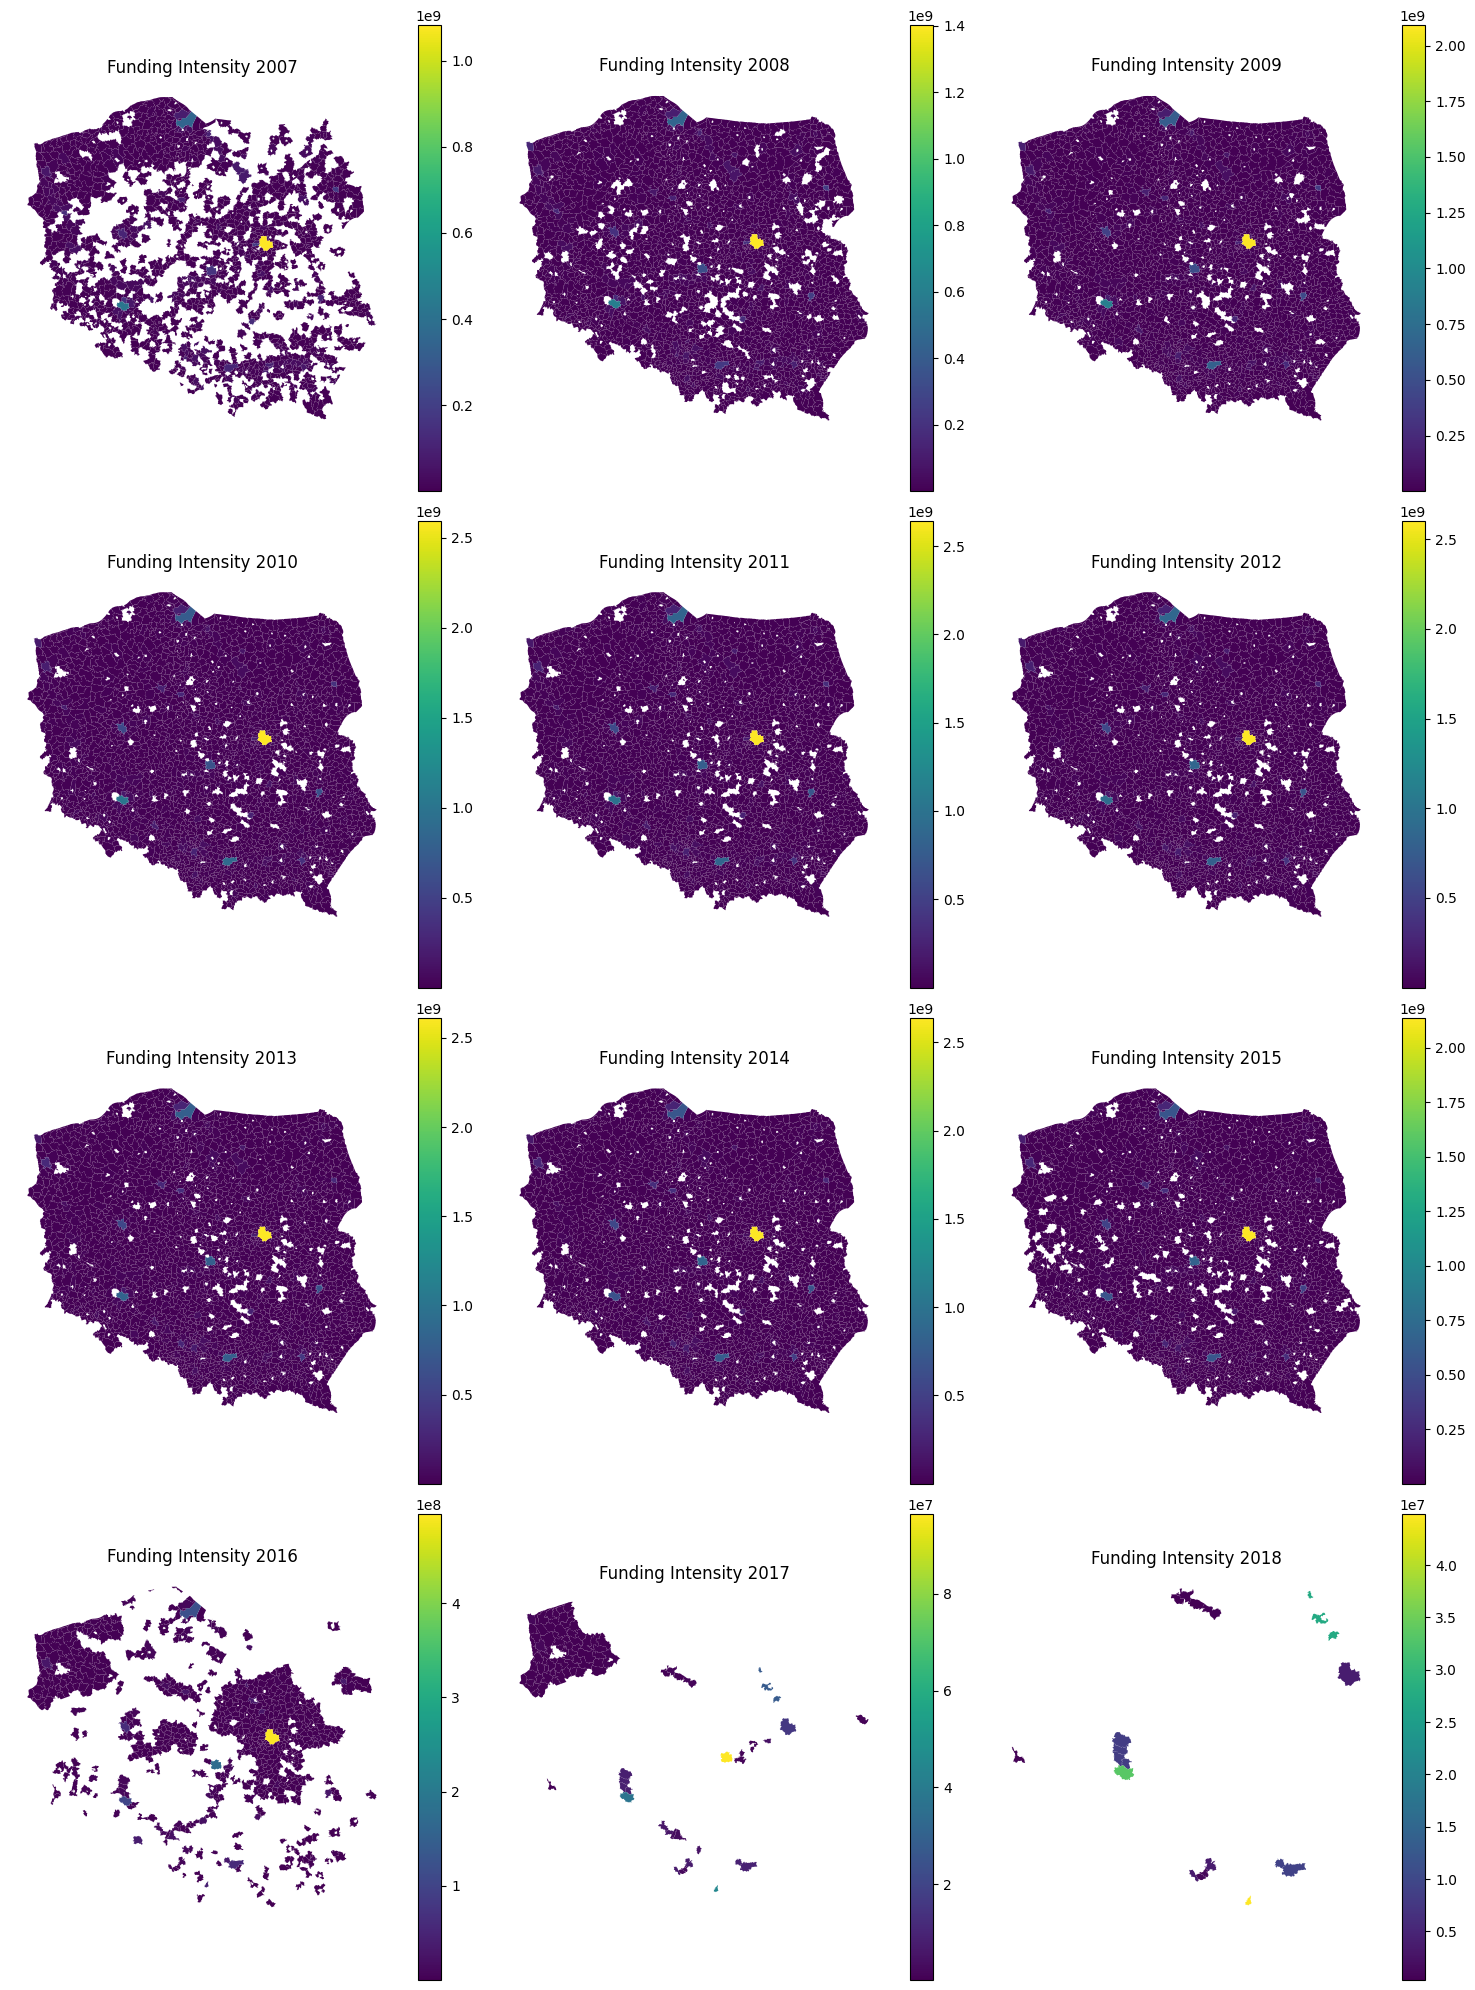

In [52]:
import matplotlib.pyplot as plt

# Assuming final_panel has columns: 'gmina_id', 'year', 'EU_subsidy_PLN'
agg = final_panel.groupby(['gmina_id', 'Year'])['EU_subsidy_PLN'].sum().reset_index()

# 2. Merge with geometries
agg['gmina_id'] = agg['gmina_id'].astype(str).str.zfill(7)
gminy_geoms['JPT_KOD_JE'] = gminy_geoms['JPT_KOD_JE'].astype(str).str.zfill(7)
merged = agg.merge(gminy_geoms, left_on='gmina_id', right_on='JPT_KOD_JE')
gdf = gpd.GeoDataFrame(merged, geometry='geometry')

# 3. Plot for selected years (adjust years as needed)
years = sorted(gdf['Year'].unique())
n_years = len(years)
ncols = 3
nrows = (n_years + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 5*nrows))
axes = axes.flatten()

for i, year in enumerate(years):
    ax = axes[i]
    gdf[gdf['Year'] == year].plot(
        column='EU_subsidy_PLN',
        ax=ax,
        cmap='viridis',
        legend=True,
        missing_kwds={"color": "lightgrey"}
    )
    ax.set_title(f'Funding Intensity {year}')
    ax.axis('off')

# Hide unused axes
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

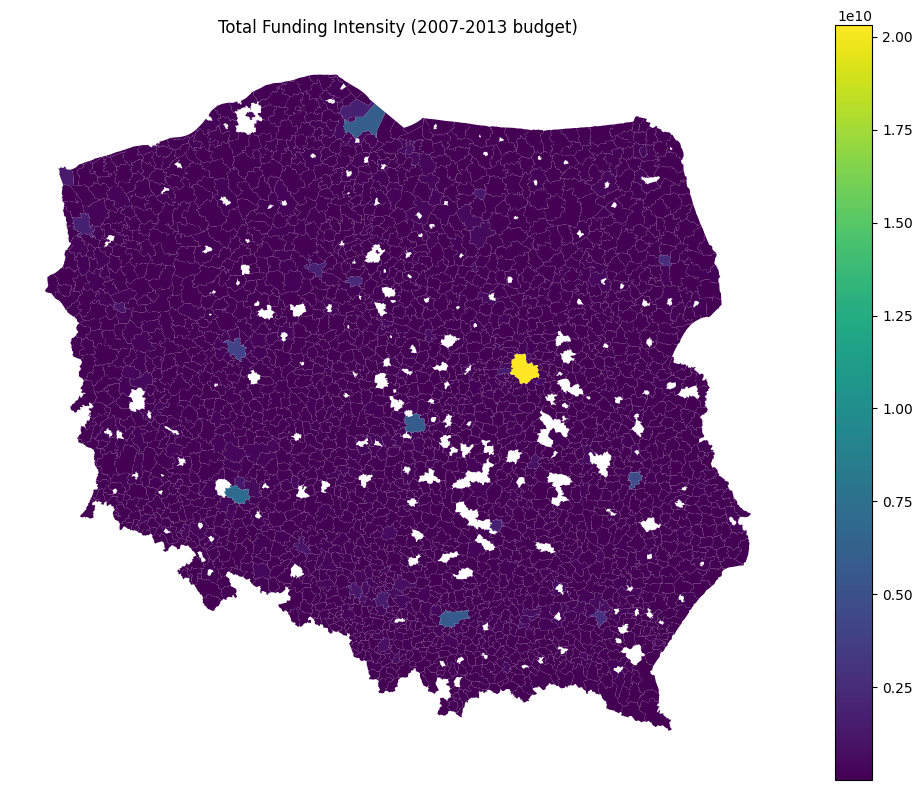

In [55]:
import matplotlib.pyplot as plt

# 1. Aggregate total funding per gmina (sum over all years)
agg_total = final_panel.groupby('gmina_id')['EU_subsidy_PLN'].sum().reset_index()

# 2. Merge with geometries
agg_total['gmina_id'] = agg_total['gmina_id'].astype(str).str.zfill(7)
gminy_geoms['JPT_KOD_JE'] = gminy_geoms['JPT_KOD_JE'].astype(str).str.zfill(7)
merged = agg_total.merge(gminy_geoms, left_on='gmina_id', right_on='JPT_KOD_JE')
gdf = gpd.GeoDataFrame(merged, geometry='geometry')

# 3. Plot the total funding intensity map
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
gdf.plot(
    column='EU_subsidy_PLN',
    ax=ax,
    cmap='viridis',
    legend=True,
    missing_kwds={"color": "lightgrey"}
)
ax.set_title('Total Funding Intensity (2007-2013 budget)')
ax.axis('off')
plt.tight_layout()
plt.show()

In [58]:
final_panel.voivodeship_id.unique()

array(['02', '04', '06', '08', '10', '12', '14', '16', '18', '20', '22',
       '24', '26', '28', '30', '32'], dtype=object)